
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Simulate Astronomical Tide using U-tide library

inputs required: 
  * Measured water levels time series at the study site 
  
in this notebook: 
  * Tidal armonic analysis based on U-tide library

### Workflow:

<div>
<img src="resources/nb01_03.png" width="300px">
</div>


Tides are simulated by determining the leading constituents using the U_Tide package applied to observed water levels. Superimposing the predicted tides as an independent process still inherently accounts for the timing of events during the calendar year (i.e., king tides in January and February due to Earth’s orbital position are associated with realistic winter weather patterns produced by the emulator). 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op

# python libs
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib

# custom libs
import utide # https://github.com/wesleybowman/UTide

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.plotting.tides import Plot_AstronomicalTide, Plot_WaterLevel, Plot_ValidateTTIDE, Plot_Validate_scatter



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/anacrueda/Documents/Proyectos/TESLA/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# Load astronomical tide historical and set simulation dates

HIST_WLs = db.Load_TIDE_hist_astro()  # water levels from tidal gauge record, research quality
WLs = HIST_WLs.sea_level[0,:]

# TG latitude
lat0 = 9.75

# Simulation dates (years)
y1_sim = 2000
y2_sim = 3000



## Measured water levels from tidal gauge

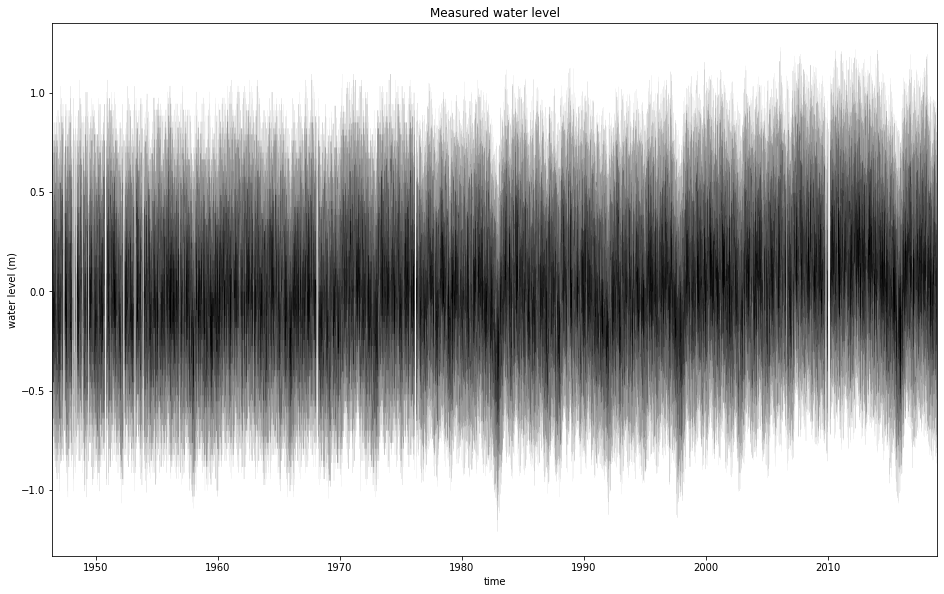

In [4]:
# --------------------------------------
# water level data

# remove water level nanmean to obtain anomaly
WLs = (WLs - np.nanmean(WLs))/1000

# Plot astronomical tide
time = WLs.time.values[:]
wl = WLs.values[:]
Plot_WaterLevel(time, wl);



## Astronomical Tide - Fitting

In [5]:
# --------------------------------------
# Utide library - Validation
coef = utide.solve(
    matplotlib.dates.date2num(time), wl,
    lat=lat0,
    nodal=True,
    method='ols',
    conf_int='MC', 
    trend=False,
)


solve: matrix prep ... solution ... diagnostics ... done.


dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'g_ci', 'A_ci', 'diagn'])
prep/calcs ... done.
dict_keys(['t_in', 'epoch', 'constit', 'min_SNR', 'min_PE', 't_mpl', 'h'])
None


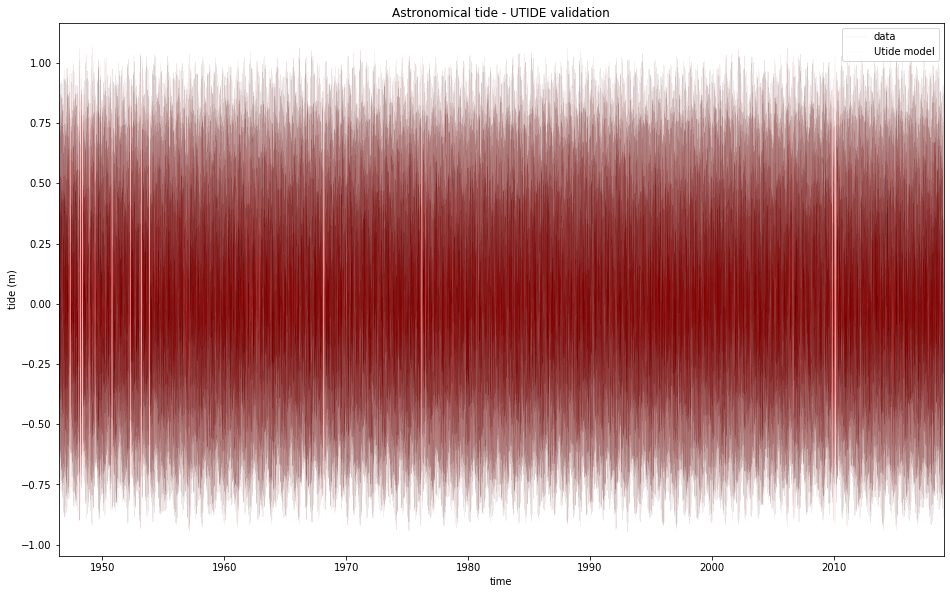

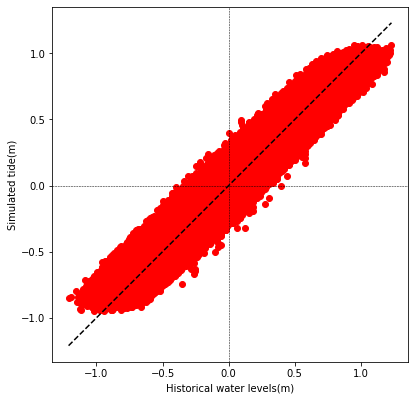

In [6]:

print(coef.keys())

tide_tt = utide.reconstruct(matplotlib.dates.date2num(time), coef)

print(tide_tt.keys())
print(tide_tt.constit)

residuals = wl-tide_tt.h

# Plot validation 
Plot_ValidateTTIDE(time, wl-residuals, tide_tt.h);
Plot_Validate_scatter(wl, tide_tt.h, 'Historical water levels(m)', 'Simulated tide(m)');


In [7]:
# HISTORICAL PREDICTED TIDE, and RESIDUALS from water level measurements

xds_hist = xr.Dataset(
            {
                'WaterLevels': (('time'), wl),
                'Residual': (('time'), residuals),
                'Predicted': (('time'), tide_tt.h),
            },
            coords = {'time': time}
        )

db.Save_TIDE_hist_astro(xds_hist)


## Astronomical Tide - Prediction

In [8]:
# --------------------------------------
# Utide library - Prediction

def utide_pred_one_year(y):
    'Predicts one year using utide library (to avoid kernel error)'
    
    # make hourly array (one year)
    d_pred = np.arange(
        np.datetime64('{0}-01-01'.format(y)), np.datetime64('{0}-01-01'.format(y+1)),
        dtype='datetime64[h]'
    )

    # reconstruct tide using utide
    return utide.reconstruct(matplotlib.dates.date2num(d_pred), coef).h


# use utide for every year
atide_pred = np.concatenate([utide_pred_one_year(y) for y in range(y1_sim, y2_sim)])

date_pred = np.arange(
    np.datetime64('{0}-01-01'.format(y1_sim)), np.datetime64('{0}-01-01'.format(y2_sim)), 
    dtype='datetime64[h]'
).astype(datetime)

# use xarray
ASTRO_sim = xr.Dataset({'astro' :(('time',), atide_pred)}, {'time' : date_pred})
print(ASTRO_sim)
    
# store astronomical tide simulation
db.Save_TIDE_sim_astro(ASTRO_sim)


prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ..

prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ..

prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ..

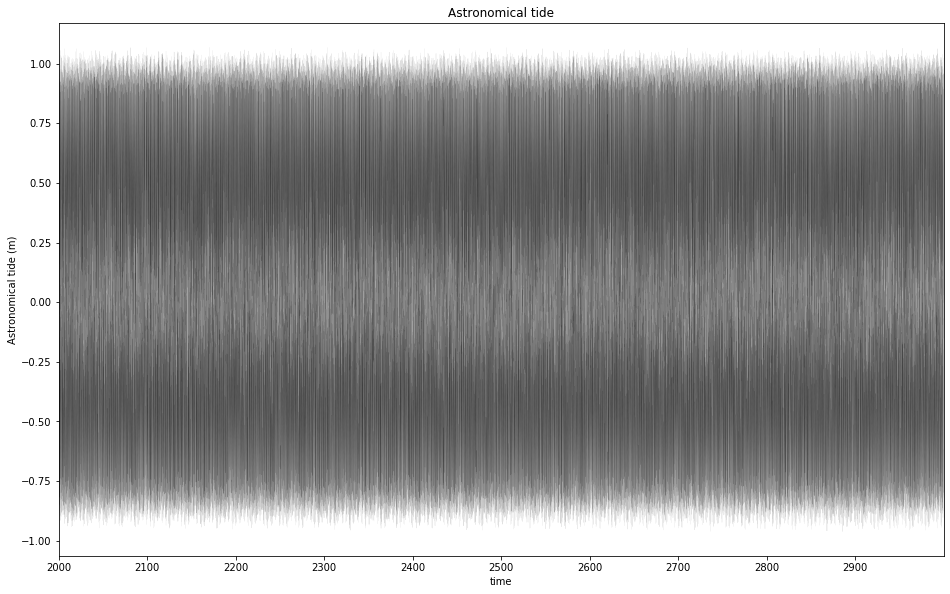

In [9]:
# Plot astronomical tide prediction
Plot_AstronomicalTide(ASTRO_sim.time.values[:], ASTRO_sim.astro.values[:]);
